In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import curve_fit
import pandas as pd
import os
from astropy.constants import c
from astropy.cosmology import WMAP9 as cosmo
import math

In [3]:
def gauss(x, a,median, sigma):
    #return 1/(sigma ** 2 * (2*np.pi) ** (1/2)) * np.exp(-(x-median) ** 2/(2*sigma**2)) #базовая функция гаусса, которая не работает
    return a * np.exp(-(x-median) ** 2/(2*sigma**2))        #дополненная функция гаусса с коэф a

In [7]:
def find_closest_to_zero(x):
  distances = np.abs(x)
  return np.argmin(distances)

In [8]:
def shifting(x, y):
  closest_idx = find_closest_to_zero(x)
  shift = y[closest_idx]
  return y - shift

In [4]:
def filt(median, sigma):                            #фильтр для 
    i = 0
    while i < len(median):
        if sigma[i] < 0:
            sigma.pop(i)
            median.pop(i)
        else:
            i+=1
    return median, sigma

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
/var/folders/sb/mw82l4pn1_x360v3pqwf3tkh0000gn/T/ipykernel_1649/4140454085.py:4: SyntaxWarning: invalid escape sequence '\s'
  table = pd.read_table(wdir + '2d_fit_ESI.txt',sep='\s+',dtype=str,skiprows=[0,1]) #файл с красными смещениями галактик
/var/folders/sb/mw82l4pn1_x360v3pqwf3tkh0000gn/T/ipykernel_1649/4140454085.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  z = float(table_1['z'][filter])                         #z - крассное смещение галактики
/var/folders/sb/mw82l4pn1_x360v3pqwf3tkh0000gn/T/ipykernel_1649/4140454085.py:31: OptimizeWarning: Covariance of the parameters could not be estimated
  rw, _ = curve_fit(gauss,fict,data[central_bin[i],round((wl_ha[0]-crval)/cdelt):round((wl_ha[1]-crval)/cdelt)], maxfev=10000, p0=[1, (6563*(1+z) - crval)/cdelt ,1]) #raw данные из curve_

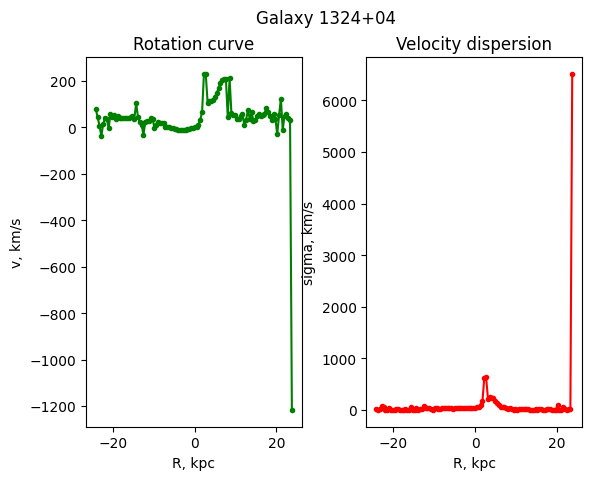

Galaxy  1324+04_0017_0018_0019_25012022_2d_starsubtr.fits


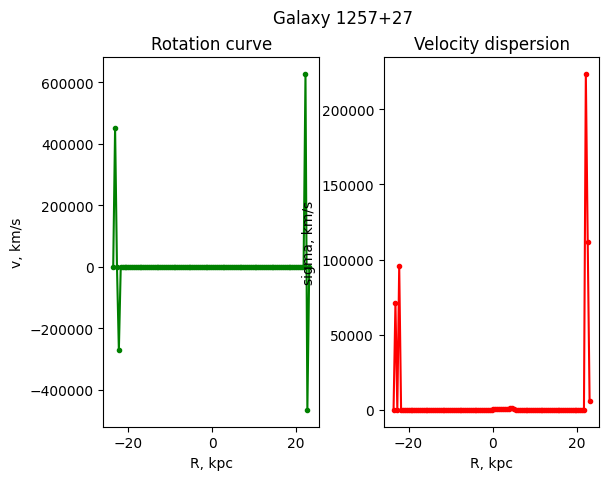

Galaxy  1257+27_0107_0108_26012022_2d_starsubtr.fits


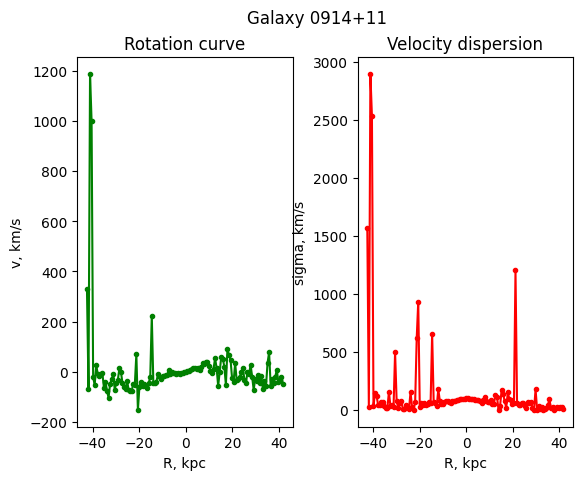

Galaxy  0914+11_0007_0008_0009_25012022_2d_starsubtr.fits


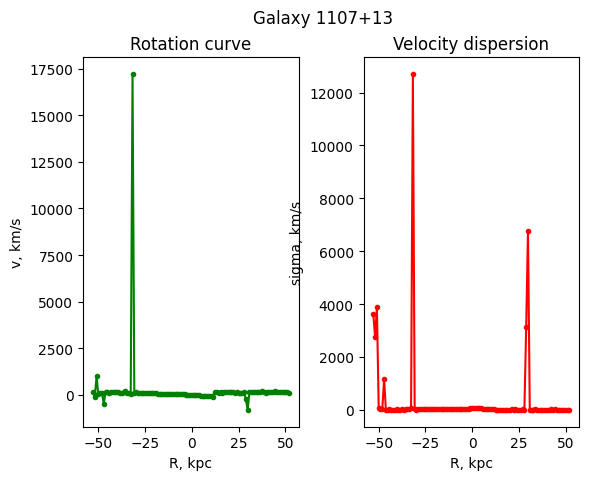

Galaxy  1107+13_0011_0012_0013_25012022_2d_starsubtr.fits


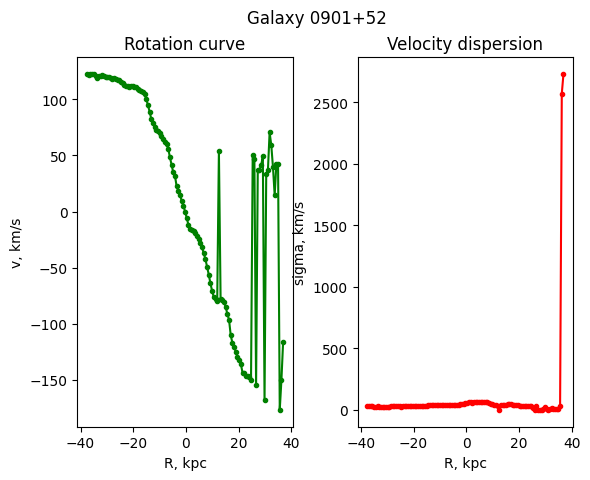

Galaxy  0901+52_26012022_0088_0089_0090_2d_starsubtr.fits


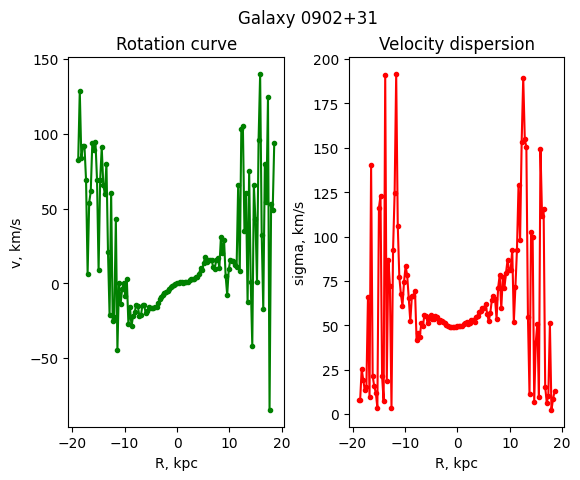

Galaxy  0902+31_0080_0081_0082_26012022_2d_starsubtr.fits


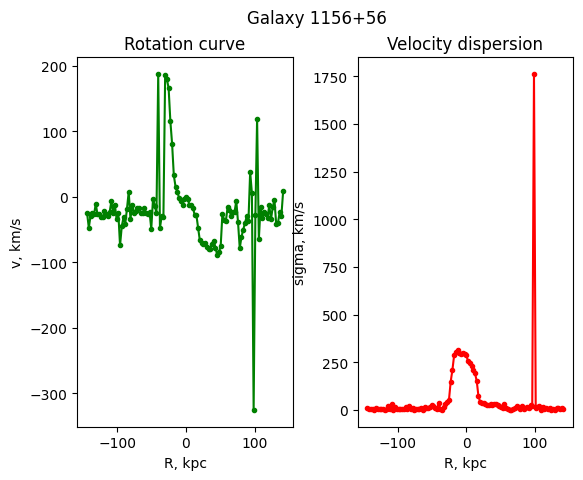

Galaxy  1156+56_0098_0099_0100_26012022_2d_starsubtr.fits
7 .0914+11_0007_0008_0009_25012022_2d_starsubtr.fits.D9nxGB


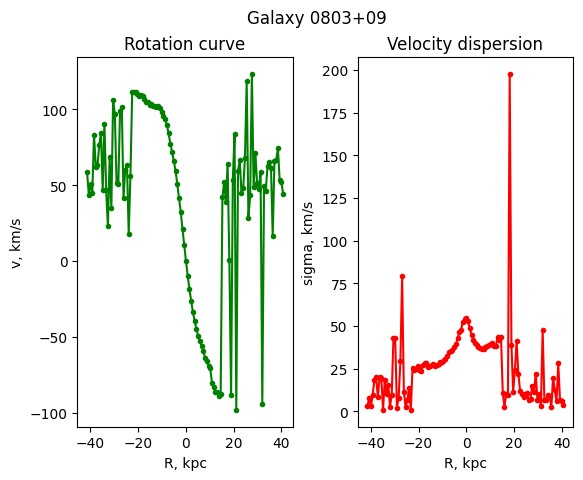

Galaxy  0803+09_25012022_0002_0003_0004_2d_starsubtr.fits


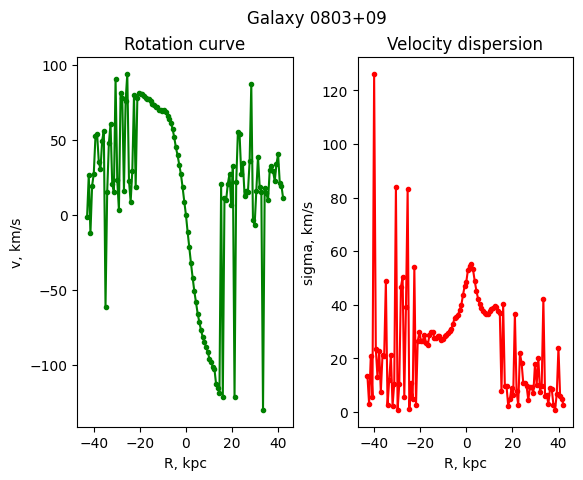

Galaxy  0803+09_0002_0003_0004_25012022_2d_starsubtr.fits


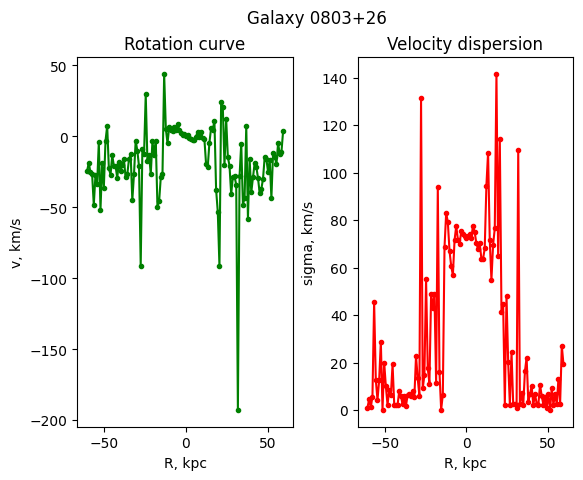

Galaxy  0803+26_0083_0084_26012022_2d_starsubtr.fits


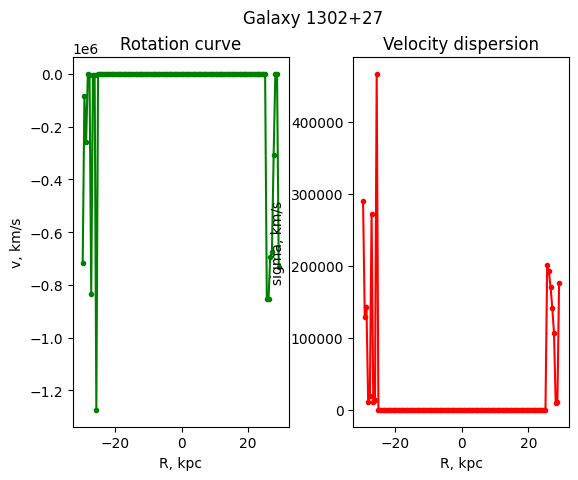

Galaxy  1302+27_0103_0104_0105_26012022_2d_starsubtr.fits


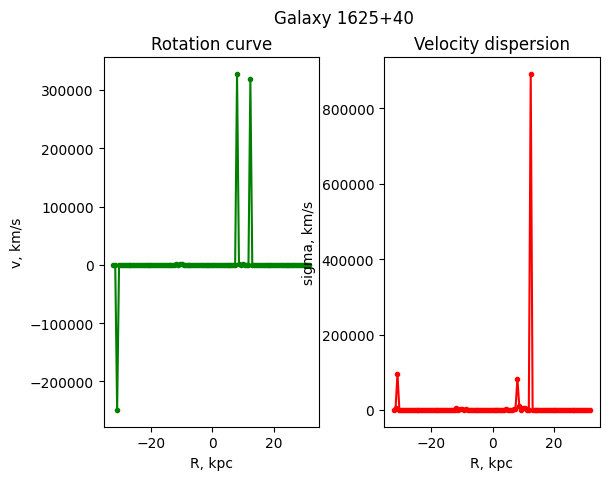

Galaxy  1625+40_0113_0114_0115_26012022_2d_starsubtr.fits
13 1005+54_0031_0032_25012022_2d_starsubtr.fits


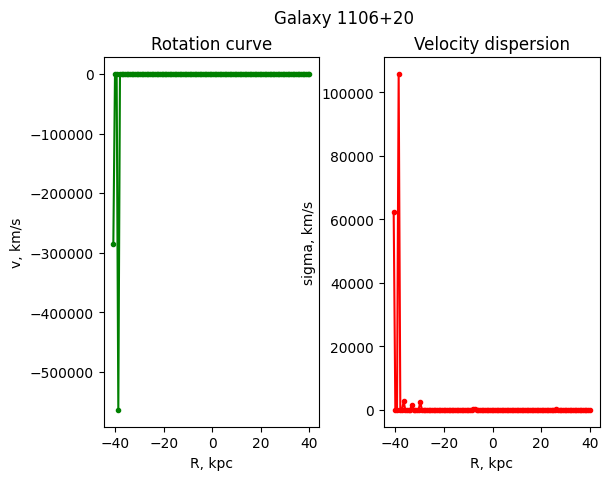

Galaxy  1106+20_0021_0022_0023_25012022_2d_starsubtr.fits


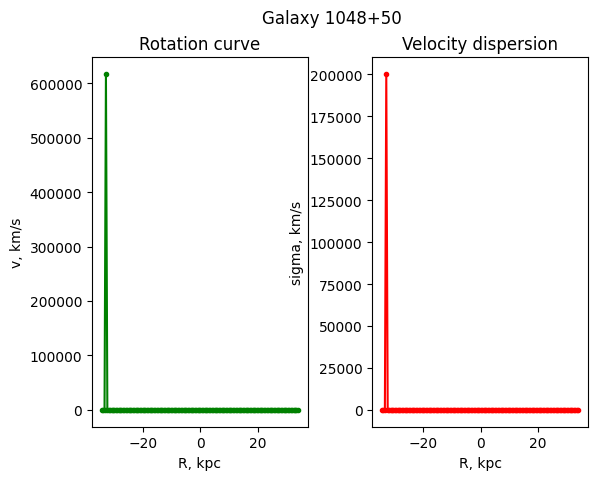

Galaxy  1048+50_0025_0026_25012022_2d_starsubtr.fits


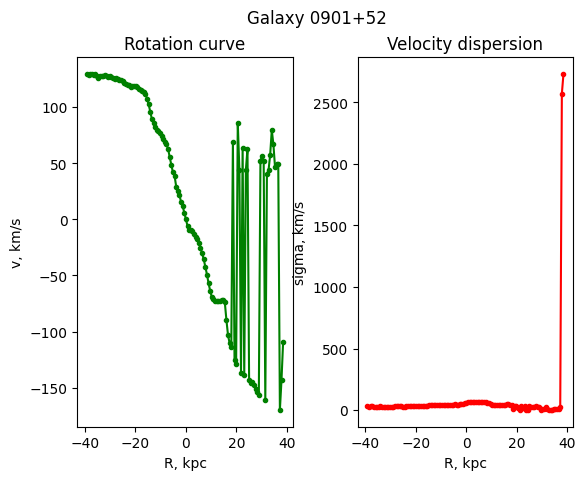

Galaxy  0901+52_0088_0089_0090_26012022_2d_starsubtr.fits
17 1005+54_0093_0094_26012022_2d_starsubtr.fits


In [18]:
wdir = '/Users/maratahmametov/Desktop/rotation-curve/'              #директория до папки ESI со спектрами
H=68
filenames = next(os.walk(wdir+'ESI/'), (None, None, []))[2]
table = pd.read_table(wdir + '2d_fit_ESI.txt',sep='\s+',dtype=str,skiprows=[0,1]) #файл с красными смещениями галактик
table_1 = table.sort_values("Galaxy")

for j in range(len(filenames)):
    filename = filenames[j]                                 #j-ый файл со спектром галактики
    filter = ((table_1['Galaxy'] == filename.split('_')[0]))#фильтр для файла с красными смещениями
    try:
        z = float(table_1['z'][filter])                         #z - крассное смещение галактики
    except TypeError:
        print(j, filename)
        continue
    spectrum = fits.open(wdir + 'ESI/' + filename)
    data = spectrum[0].data                                 #data - массив со спектром. Интенсивность(не длинны волн)
    crval = spectrum[0].header['CRVAL1']
    cdelt = spectrum[0].header['CDELT1']
    naxis2 =spectrum[0].header['NAXIS2']
    cdelt2 =spectrum[0].header['CDELT2']
    #wl = crval + cdelt*np.array(range(len(data[10,:]))) #перевод из пикселей в ангстремы длины спектра(полной длины)                                         
    span = 70
    wl_ha = [6563*(1+z)-span, 6563*(1+z)+span]                  #длина волны H_alpha с учетом красного смещения в А
    central_bin = np.array([i for i in range(int(len(data[:,span])/2 - span), int(len(data[:,span])/2 + span))]) #центр бина в пикселях НУЖНО ЧТО ТО ПРИДУМАТЬ С ГРАНИЦАМИ ЦЕНТРАЛЬНОГО БИНА, границы +- 30 пикселей относительно центра

#wli = np.nansum(data[central_bin,:], axis=0)        #суммируем значение value для всех "столбиков"
    ans = [i for i in range(central_bin[-1] - central_bin[0] + 1)]                          #массив, в который мы запишем медианы и сигмы
    fict = [i for i in range(round((wl_ha[0]-crval)/cdelt),round((wl_ha[1]-crval)/cdelt))]  #массив, который просто необходим

    for i in range(len(central_bin)):
        rw, _ = curve_fit(gauss,fict,data[central_bin[i],round((wl_ha[0]-crval)/cdelt):round((wl_ha[1]-crval)/cdelt)], maxfev=10000, p0=[1, (6563*(1+z) - crval)/cdelt ,1]) #raw данные из curve_fit
        a, median, sigma = rw   #коэф а(для гаусса), медиана i-ой строки, сигма i-ой строки
        ans[i] = rw             #записываем в ответ медиану, сигму и коэф а
######################ВИЗУАЛИЗАЦИЯ I-ой СТРОКИ И НОРМАЛЬНОГО РАСПРЕДЕЛЕНИЯ
        #plt.plot(fict,data[central_bin[i],round((wl_ha[0]-crval)/cdelt):round((wl_ha[1]-crval)/cdelt)],'b-',marker='.')
        #beach = np.linspace(round((wl_ha[0]-crval)/cdelt),round((wl_ha[1]-crval)/cdelt),2000)
        #plt.plot(beach,gauss(beach,a,median,sigma),'r-')
        #plt.xlim(wl_ha[0],wl_ha[1])
        #plt.title(i)
        #plt.show()
######################
    size_arcsec = z*c.value/H*2*math.pi/360/3600
    median = np.array(ans)[:,1]
    sigma = np.array(ans)[:,2]
    median, sigma = filt(list(median),list(sigma))
    #print(len(median))
    median = [i*cdelt + crval for i in median]
    sigm = [i*cdelt for i in sigma]
    speed = [(i/(6563) - 1 - z)*c.value / 1000 for i in median]
    sigma = [i/(6563*(1+z))*c.value / 1000 for i in sigm]
    length = [(i-len(median)/2)*size_arcsec*cdelt2 for i in range(len(median))]
    speed = shifting(length, speed)
    
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].plot(length, speed, 'g-', marker='.')           #рисуем кривую вращения в XO - пикселях(переводим в ангстремы, а потом в расстояние по z), Y0 - пикселях(перевести в угловые секунды а потом в скорость в км/с по хабблу)
    ax[1].plot(length, sigma, 'r-', marker='.')             #рисуем то же самое для сигмы
    #plt.xlim(round((wl_ha[0]-crval)/cdelt),round((wl_ha[1]-crval)/cdelt))   #ограничение по оси X0, чтобы рисовало в пределах линии Ha
    ax[0].set_xlabel('R, kpc')
    ax[0].set_ylabel('v, km/s')
    ax[1].set_xlabel('R, kpc')
    ax[1].set_ylabel('sigma, km/s')
    ax[0].set_title('Rotation curve')
    ax[1].set_title('Velocity dispersion')
    plt.subplots_adjust(wspace=0.3)
    fig.suptitle('Galaxy '+ filename[:7])
    plt.show()
    print('Galaxy ', filename)